In [1]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [2]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

In [3]:
#Read the data from a csv file onto a pandas dataframe
df=pd.read_csv("data/diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


It's important to check for null or missing values in the data, as that can affect the performance of a model.

In [6]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Using the isnull() method showed no nulls in the dataset, however it is evident that there 0.0 values in some of the columns. In two of the columns it is appropriate to have 0, as this is relevant to the representation of the data. For example in the pregnancy columns, a 0 indicates that the patient has had no pregnancies. Also the outcome 0 indicates the class which determines that a person does not have diabetes.

Knowing that the columns for 'Pregnancies' and 'Outcome' have appropriate zeros, we can get convert the zeros on all other columns in to NaN values, this will potentially make further manipulation and data processing far simpler. First we can grab the names for the other columns.

In [7]:
cols_valid_zeros = ['Pregnancies','Outcome']
cols_null_zeros = df.columns[(df == 0).any() & ~df.columns.isin(cols_valid_zeros)]
display(cols_null_zeros)

Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'], dtype='object')

The following function goes through the dataframe and looks at the columns specified in cols, then replaces any 0 values to Nan values

In [8]:
def nanConvert(data_df,cols):
    for c in cols:
        df[c] = df[c].replace(0, np.nan)
    return df
             

In [9]:
df = nanConvert(df,cols_null_zeros)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,NaN,NaN,30.1,0.349,47,1


Once we replaced all 0 values with NaN, we can do some data imputations to fill the NaNs.

Mean/Median/Mode Imputation: This is the simplest form of imputation. Missing values are filled with the mean, median, or mode (most frequent value) of the column. Mean is used for continuous data, while median is more robust to outliers. Mode is used for categorical data. It's the simplest form of imputation, requiring minimal computation, but doesn't account for any correlations between features.

- Complexity: Very Low
- Overhead: Very Low



Random Imputation: Missing values are filled with a random observation from the same column. This method preserves the distribution but can add randomness to the dataset, which might not always be desirable. Slightly more complex due to the randomness but still very straightforward and fast.

- Complexity: Low
- Overhead: Low


Last Observation Carried Forward (LOCF) & Next Observation Carried Backward (NOCB): Common in time series data, LOCF fills missing values with the last observed value, and NOCB fills them with the next observed value. These methods assume the data points are closely related in time.

- Complexity: Low
- Overhead: Low

Mainly used for time series data. The complexity is still low, but the method is slightly more sophisticated than mean/median/mode because it considers the order of data.

Linear Interpolation: Another technique used in time series data, where missing values are filled based on linear interpolation between observed values. It's suitable for data with a linear trend.

- Complexity: Moderate
- Overhead: Low to Moderate

For time series data, this method considers the trend between observations. It's more complex but still relatively fast.


K-Nearest Neighbors (KNN) Imputation: This method fills missing values based on the K-nearest neighbors. It calculates the similarity between observations and uses the mean or median of the K most similar observations for imputation.

- Complexity: High
- Overhead: High

KNN requires calculating distances between observations, which can be computationally intensive, especially for large datasets.

Regression Imputation: Missing values are estimated using a regression model. The model is built using the observed values, and the missing values are filled based on the predictions of this model.

- Complexity: High
- Overhead: High

Involves building regression models for each feature with missing values, which can be computationally intensive, especially with many features or complex models.


Multiple Imputation: It involves creating multiple imputations (sets of values) for missing data points. The analysis is performed on each set, and the results are pooled to get final estimates. It accounts for the uncertainty in the imputations.

- Complexity: Very High
- Overhead: Very High

Creating multiple imputations for missing data and then analyzing each to pool results significantly increases complexity and computational load.


Hot-Deck Imputation: A randomly selected value from an individual in the dataset who has similar values on other variables is used to fill in the missing value. It’s similar to KNN but doesn't explicitly use a distance metric.


H-Deck Imputation

- Complexity: Moderate
- Overhead: Moderate

This method requires matching profiles within a dataset, increasing complexity and computational time

Cold-Deck Imputation: Similar to hot-deck, but the value to fill in the missing data is taken from another dataset that is believed to be similar to the one with missing data.

- Complexity: Moderate
- Overhead: Moderate

Similar to hot-deck, but potentially requires accessing and processing external datasets, which can add to the complexity.


Imputation Using Deep Learning: Advanced methods like autoencoders can be used for imputation, where the model learns to predict missing values based on patterns learned from the data.

- Complexity: Very High
- Overhead: Very High

Designing, training, and using deep learning models for imputation is the most complex and computationally intensive, especially for large datasets and complex models.ationally intensive, especially for large datasets and complex models.r large datasets and complex models.

Due to it's low complexity and low overhead, we will use the mean imputations

# SimpleImputer

**class sklearn.impute.SimpleImputer(*, missing_values=nan, strategy='mean', fill_value=None, copy=True, add_indicator=False, keep_empty_features=False)**

Univariate imputer for completing missing values with simple strategies.

Replace missing values using a descriptive statistic (e.g. mean, median, or most frequent) along each column, or using a constant value.

**Source:** Pedregosa, F., Varoquaux, G., Gramfort, A., et al. "Scikit-learn: Machine Learning in Python." Journal of Machine Learning Research, vol. 12, 2011, pp. 2825–2830.

Typically, the data should be split into training and testing sets before any imputation is performed. This is crucial for preventing data leakage. Data leakage occurs when information from the test set is inadvertently used to influence the training process, leading to overly optimistic performance estimates.

After splitting the data, the imputer should be fit on the training set only. This means calculating the imputation values based on the training data alone.mance.

In [10]:
X = df.drop('Outcome', axis=1)  # Features
y = df['Outcome']            

In [11]:
display(X)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30
766,1,126.0,60.0,NaN,NaN,30.1,0.349,47


In [12]:
display(y)

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

Split the data into the training and testing sets.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# mean imputation using the SimpleImputer Class from Scikit Learn
imp_mean = SimpleImputer(strategy='mean')

# Fit on the training data and transform it
X_train_imputed = imp_mean.fit_transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)

# Transform the test data based on the training fit
X_test_imputed = imp_mean.transform(X_test)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns, index=X_test.index)

Standard scaling should typically be done after imputation.

Since scaling involves adjusting the distribution of data based on its mean and standard deviati. If e da scaling is done a before imputing missing value then the model is e working with an incomplete dataset. The calculated mean and standard deviation would only reflect the observed (non-missing) data points, which might not represent the true distribution of the complete dataset.


If mean or median imputation is  being used, the process will be influenced by the scale of the features. Imputing before scaling ensures that the imputation reflects the true scale of the data. For instance, imputing the mean of a feature that hasn't been scaled might be more meaningful, as the mean will be in the same units as the original dng data.

Scaling the features is crucial for some models, but not necessary for others.

The appropriateness of StandardScaler for different machine learning models depends on how each model handles feature scaling and the distribution of the features. For example:

Logistic Regression: Yes, feature scaling is beneficial because logistic regression coefficients can be influenced by the scale of the features, especially when using regularization.

Naive Bayes: Not typically necessary. Gaussian Naive Bayes is designed to handle data in its natural distribution since it assumes that the features follow a Gaussian distribution. However, for other types of Naive Bayes (e.g., MultinomialNB for count data), scaling is not applicable.

K-Nearest Neighbour (KNN): Yes, KNN is distance-based, meaning that the scale of the features directly impacts the calculation of distances between data points. Standard scaling is often crucial for models like KNN.

Decision Tree: No, decision trees and tree-based models (like Random Forests and gradient boosting models) do not require feature scaling. These models are not sensitive to the variance in the data and can handle varied feature scales.

Support Vector Machine (SVM) - Linear and RBF kernels: Yes, SVMs are sensitive to the scale of the data, especially with kernel methods (like RBF). Feature scaling can greatly influence the performance of SVMs by affecting the decision boundary.

Random Forest: No, similar to decision trees, Random Forest models are not sensitive to the scale of the features. Scaling does not generally impact their performance.

eXtreme Gradient Boost (XGBClassifier): No, XGBoost is also a tree-based model and is typically robust to the scale of the features. Feature scaling is not usually required.


For distance-based models (like Logistic Regression, KNN, and SVM), scaling is important because these models are sensitive to the scale of the features. For probability-based models (like Naive Bayes), scaling might not be necessary and depends on the specific type of Naive Bayes used. For tree-based models (like Decision Trees, Random Forest, and XGBoost), scaling is generally not needed as these models are not sensitive to the feature scale.

In [15]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [16]:
models_scaled = []
models_scaled.append(("Logistic Regression", LogisticRegression()))
models_scaled.append(("K-Nearest Neighbour", KNeighborsClassifier(n_neighbors=3)))
# Enable probability estimates for SVM models
models_scaled.append(("Support Vector Machine-linear", SVC(kernel="linear", C=0.2, probability=True)))
models_scaled.append(("Support Vector Machine-rbf", SVC(kernel="rbf", probability=True)))

In [17]:
models_unscaled = []
models_unscaled.append(("Naive Bayes", GaussianNB()))
models_unscaled.append(("Decision Tree", DecisionTreeClassifier()))
models_unscaled.append(("Random Forest", RandomForestClassifier(n_estimators=5)))
models_unscaled.append(("eXtreme Gradient Boost", XGBClassifier()))

In [18]:

import matplotlib.pyplot as plt

def evaluate(model, name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (ROC AUC = {roc_auc:.2f})')
    else:
        print(f"{name} does not support predict_proba. ROC AUC cannot be calculated.")
        roc_auc = "N/A"
    
    # Calculate evaluation metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    Error = (fp + fn)/(tn + fp + fn + tp)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    specificity = tn / (tn + fp)
    f1 = f1_score(y_test, y_pred, average='binary')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    

    print("-"*30)
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Error: {Error*100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC: {roc_auc}" if roc_auc != "N/A" else "ROC AUC: N/A")
    print("-"*30)
    
    if roc_auc != "N/A":
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance level')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()




------------------------------
Model: Logistic Regression
Accuracy: 75.32%
Error: 24.68%
Precision: 0.67
Recall: 0.62
Specificity: 0.83
F1 Score: 0.64
ROC AUC: 0.8240587695133149
------------------------------


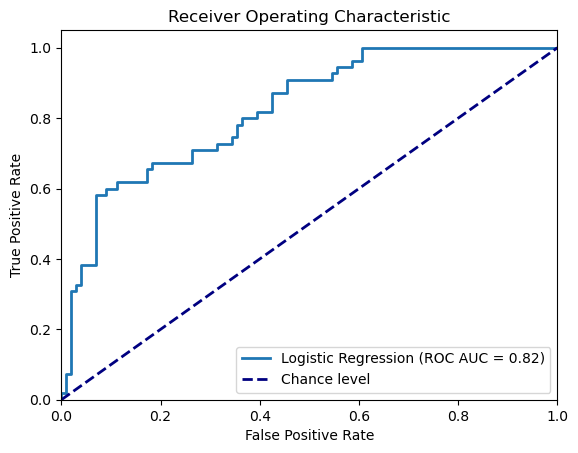

------------------------------
Model: K-Nearest Neighbour
Accuracy: 72.08%
Error: 27.92%
Precision: 0.59
Recall: 0.69
Specificity: 0.74
F1 Score: 0.64
ROC AUC: 0.7526170798898071
------------------------------


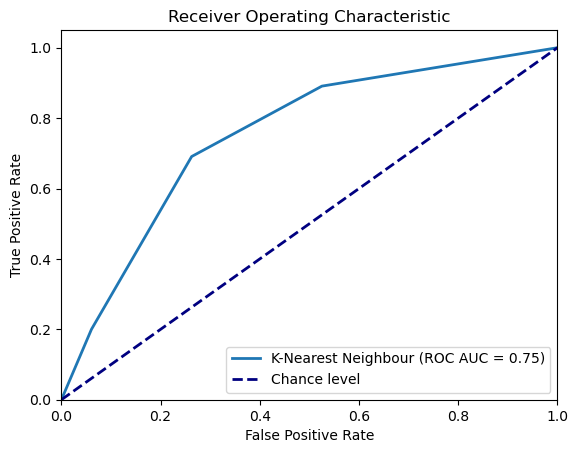

------------------------------
Model: Support Vector Machine-linear
Accuracy: 75.32%
Error: 24.68%
Precision: 0.67
Recall: 0.62
Specificity: 0.83
F1 Score: 0.64
ROC AUC: 0.8268135904499541
------------------------------


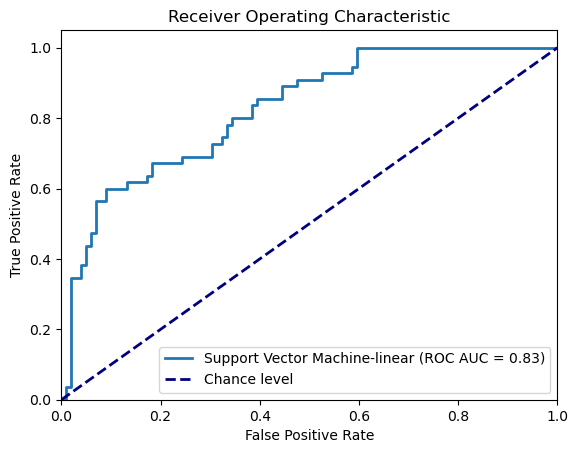

------------------------------
Model: Support Vector Machine-rbf
Accuracy: 75.32%
Error: 24.68%
Precision: 0.68
Recall: 0.58
Specificity: 0.85
F1 Score: 0.63
ROC AUC: 0.8101010101010101
------------------------------


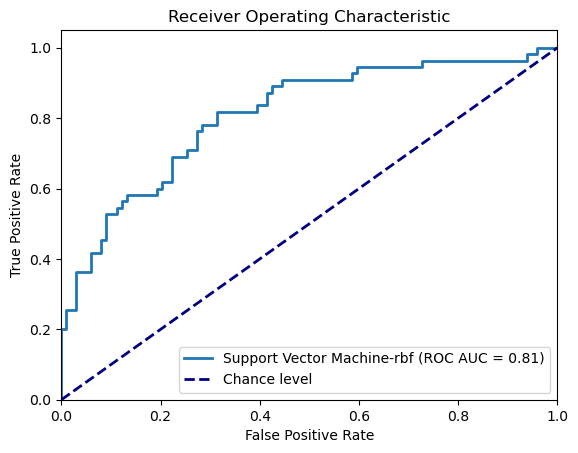

In [19]:
# Iterate over each model, train, and evaluate it
for name, model in models_scaled:
    evaluate(model,name,X_train_scaled,y_train,X_test_scaled,y_test)

------------------------------
Model: Naive Bayes
Accuracy: 75.32%
Error: 24.68%
Precision: 0.64
Recall: 0.69
Specificity: 0.79
F1 Score: 0.67
ROC AUC: 0.8330578512396694
------------------------------


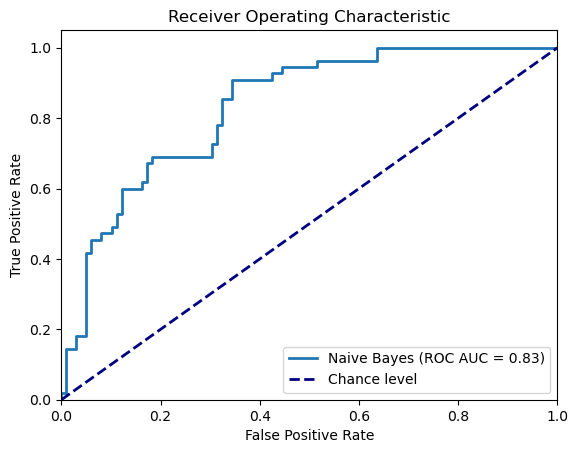

------------------------------
Model: Decision Tree
Accuracy: 73.38%
Error: 26.62%
Precision: 0.62
Recall: 0.65
Specificity: 0.78
F1 Score: 0.64
ROC AUC: 0.7161616161616162
------------------------------


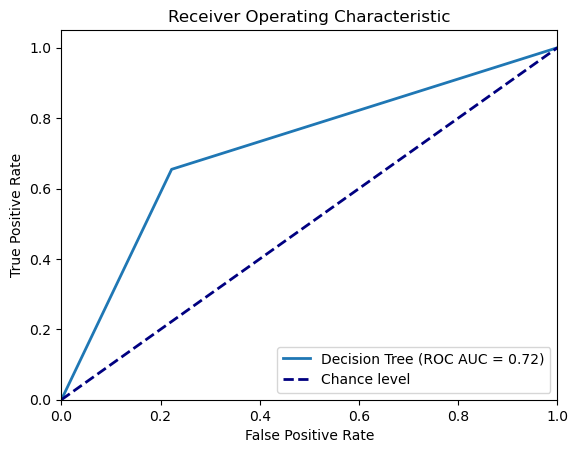

------------------------------
Model: Random Forest
Accuracy: 72.73%
Error: 27.27%
Precision: 0.62
Recall: 0.62
Specificity: 0.79
F1 Score: 0.62
ROC AUC: 0.7505968778696052
------------------------------


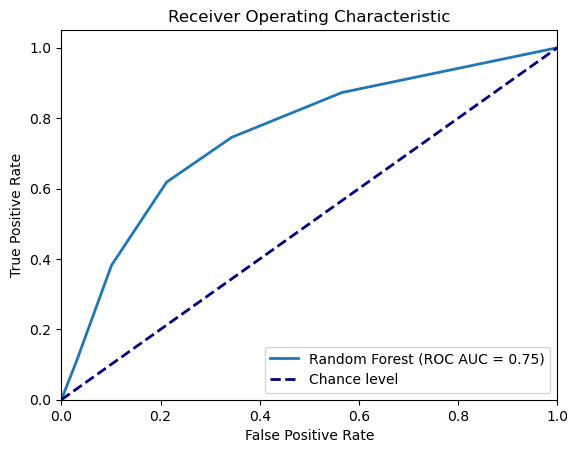

------------------------------
Model: eXtreme Gradient Boost
Accuracy: 72.08%
Error: 27.92%
Precision: 0.60
Recall: 0.67
Specificity: 0.75
F1 Score: 0.63
ROC AUC: 0.7763085399449036
------------------------------


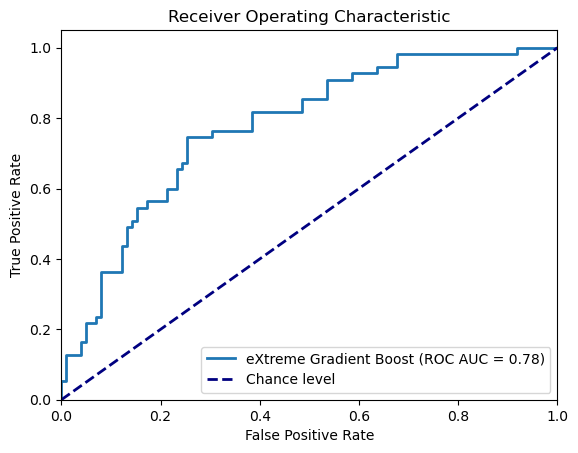

In [20]:
# Iterate over each model, train, and evaluate it
for name, model in models_unscaled:
    evaluate(model,name,X_train_imputed,y_train,X_test_imputed,y_test)